In [ ]:
import torch
print(torch.cuda.is_available())         # should return True
print(torch.cuda.get_device_name(0))     # should say "NVIDIA GeForce RTX 3060"


Imports 

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


import os

# For data manipulation and analysis 
import pandas as pd

# For numerical operations and array handling 
import numpy as np

# For creating plots and visualisations
import matplotlib.pylab as plt

# For advanced data visualisations 
#import seaborn as sns
# For file pattern matching 
import glob as glob

# For audio processing 
import librosa

# For displaying audio data visually 
import librosa.display

# For playing audio directly in notebooks 
import IPython.display as ipd

import wave

#for reproduability 
import random

#for the fodler re-structure 150 sample 
import shutil





Loading dataset 

In [3]:
base_dir = os.path.join(os.getcwd(), 'datasets', 'voice-based-id-recognition')
diffPhrase = os.path.join(base_dir,'differentPhrase')
samePhrase = os.path.join(base_dir,'samePhrase')

Checking Dataset Location existance

In [4]:
# Check if the training directory exists
if os.path.exists(diffPhrase):
    print("differentPhrase Directory: ")
    print(os.listdir(diffPhrase))
else:
    print("Directory does not exist:", diffPhrase) 
   

# Check if the testing directory exists
if os.path.exists(samePhrase):
    
    print("samePhrase Directory: ")
    print(os.listdir(samePhrase))
else:
    print("Directory does not exist:", samePhrase)

Directory does not exist: c:\Users\Aadil\Desktop\Voice-Auth-DF-System\ml-models\datasets\voice-based-id-recognition\differentPhrase
Directory does not exist: c:\Users\Aadil\Desktop\Voice-Auth-DF-System\ml-models\datasets\voice-based-id-recognition\samePhrase


Listen to audio files

In [5]:
"""

file_path = r"C:\Users\Aadil\Desktop\Voice-Auth-DF-System\ml-models\datasets\voice-based-id-recognition\differentPhrase\1\1-11.wav"

with wave.open(file_path, 'rb') as wav_file:
    num_frames = wav_file.getnframes()
    sample_rate = wav_file.getframerate()
    sample_width = wav_file.getsampwidth()
    channels = wav_file.getnchannels()
    audio_data = wav_file.readframes(num_frames)

# Convert raw bytes to numpy array
audio_np = np.frombuffer(audio_data, dtype=np.int16)

# If stereo, reshape
if channels == 2:
    audio_np = audio_np.reshape(-1, 2)

ipd.Audio(audio_np, rate=sample_rate)


"""


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 18-19: truncated \UXXXXXXXX escape (3963867248.py, line 22)

Pre-Processing 

In [ ]:
#Dataset split
base_path = os.path.join(os.getcwd(), 'datasets', 'vox1_dev')
print(base_path)

#Each folder contains a different speaker

speaker_count = sum(os.path.isdir(os.path.join(base_path, entry)) for entry in os.listdir(base_path))
print("Number of original Speakers : ",speaker_count)
#Select a random selection of speakers, as inital dataset of 1211 speakers is roughly 30GB. will take a sample of 150 speakers(12.3%), aroudn 3.7GB

""""
# Destination path for subset
train_path = os.path.join(os.getcwd(), 'datasets', 'vox1_subset_150')
os.makedirs(train_path, exist_ok=True)


# Set seed and select random 150 speakers
random.seed(42)
all_speakers = [entry for entry in os.listdir(base_path)
                if os.path.isdir(os.path.join(base_path, entry))]
selected_speakers = random.sample(all_speakers, 150)

# Copy selected speakers and their full contents to the subset folder
for speaker in selected_speakers:
    src_speaker_path = os.path.join(base_path, speaker)
    dest_speaker_path = os.path.join(train_path, speaker)
    shutil.copytree(src_speaker_path, dest_speaker_path)

#print(f"Subset dataset created at: {train_path}")
"""

# Print the selected speaker folders
count = 0
#print("Selected speakers:")
for speaker in selected_speakers:
    count +=1
    #print(speaker)

print("Number of train Speakers : ",count)



test_path = os.path.join(os.getcwd(), 'datasets', 'vox1_subset_test')

test_speaker_count = sum(os.path.isdir(os.path.join(test_path, entry)) for entry in os.listdir(test_path))
print("Number of test Speakers : ",test_speaker_count)

testing to see if files are copied in both train and test, tested using hash of the files to compare. 

In [ ]:
import os
import hashlib

def file_hash(filepath):
    hasher = hashlib.sha256()
    with open(filepath, 'rb') as f:
        hasher.update(f.read())
    return hasher.hexdigest()

test_path = os.path.join(os.getcwd(), 'datasets', 'vox1_subset_test')
train_path = os.path.join(os.getcwd(), 'datasets', 'vox1_subset_150')

def get_file_map(base_path):
    file_map = {}
    for root, _, files in os.walk(base_path):
        for file in files:
            file_map[file] = os.path.join(root, file)
    return file_map

test_files = get_file_map(test_path)
train_files = get_file_map(train_path)

common = set(test_files).intersection(train_files)
print(f"Found {len(common)} common files.\n")

for filename in sorted(common):
    test_file = test_files[filename]
    train_file = train_files[filename]

    same = file_hash(test_file) == file_hash(train_file)
    print(f"{filename} - {'Same' if same else 'Different'}")



Spliting train and validaion(80/20 split)

In [ ]:

source_path = os.path.join(os.getcwd(), 'datasets', 'vox1_subset_150')

train_folder = os.path.join(source_path, 'train_data')
val_folder = os.path.join(source_path, 'val_data')

os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

speaker_folders = [folder for folder in os.listdir(source_path)
                   if os.path.isdir(os.path.join(source_path, folder)) and folder not in ['train_data', 'val_data']]

random.seed(42)
random.shuffle(speaker_folders)
split_index = int(0.8 * len(speaker_folders))
train_speakers = speaker_folders[:split_index]
val_speakers = speaker_folders[split_index:]

for speaker in train_speakers:
    src = os.path.join(source_path, speaker)
    dst = os.path.join(train_folder, speaker)
    shutil.move(src, dst)

for speaker in val_speakers:
    src = os.path.join(source_path, speaker)
    dst = os.path.join(val_folder, speaker)
    shutil.move(src, dst)

print(f"{len(train_speakers)} speakers moved to train_data, {len(val_speakers)} to val_data.")



checking number of files, i.e the size to see how long it may take

In [ ]:
import os

source_path = os.path.join(os.getcwd(), 'datasets', 'vox1_subset_150')

# Train and validation folders
train_folder = os.path.join(source_path, 'train_data')
val_folder = os.path.join(source_path, 'val_data')

def count_wav_files(folder_path):
    wav_count = 0
    for root, _, files in os.walk(folder_path):
        wav_files = [f for f in files if f.lower().endswith('.wav')]
        wav_count += len(wav_files)
    return wav_count

train_count = count_wav_files(train_folder)
val_count = count_wav_files(val_folder)
total_count = train_count + val_count

print(f"Train .wav files: {train_count}")
print(f"Val .wav files: {val_count}")
print(f"Total .wav files: {total_count}")


#find avreage audio file length to see what the set time shodul be for the pre proicessing
import librosa
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
def check_audio_durations(folder_path, sr=22050, plot_hist=True):
    folder = Path(folder_path)
    durations = []

    print(f"Scanning audio files in {folder}...")

    for wav_file in folder.rglob("*.wav"):
        try:
            y, _ = librosa.load(wav_file, sr=sr)
            duration = librosa.get_duration(y=y, sr=sr)
            durations.append(duration)
        except Exception as e:
             print(f"Failed to load {wav_file}: {e}")

    durations = np.array(durations)

    print(f"\n Duration Stats (in seconds):")
    print(f"Average: {np.mean(durations):.2f}s")
    print(f"Min:     {np.min(durations):.2f}s")
    print(f"Max:     {np.max(durations):.2f}s")
    print(f"Std dev: {np.std(durations):.2f}s")
    print(f"Total files: {len(durations)}")

    if plot_hist:
        plt.hist(durations, bins=50, edgecolor='black')
        plt.title("Audio Duration Distribution")
        plt.xlabel("Duration (seconds)")
        plt.ylabel("Number of files")
        plt.grid(True)
        plt.show()

    return durations

check_audio_durations('datasets/vox1_subset_150/train_data')
check_audio_durations('datasets/vox1_subset_150/val_data')
check_audio_durations('datasets/vox1_subset_test')


Data Pre processing 

In [ ]:
import librosa
import noisereduce as nr
import numpy as np
import soundfile as sf
from pathlib import Path

def preprocess_audio(y, sr, target_duration=6.0, apply_preemphasis=False, apply_reduction=False, coef=0.5, normalise='rms'):
    
    # Trim leading/trailing silence
    y, _ = librosa.effects.trim(y)

    # Apply noise reduction / dereverberation
    if apply_reduction:
        y = nr.reduce_noise(y=y, sr=sr)

    # Apply pre-emphasis filter
    if apply_preemphasis:
        y = librosa.effects.preemphasis(y, coef=coef)

    # Normalisation method
    if normalise == 'rms':
        rms = np.sqrt(np.mean(y**2))
        y = y / (rms + 1e-6)
    elif normalise == 'peak':
        y = y / (np.max(np.abs(y)) + 1e-6)

    # Duration control: pad or truncate
    target_length = int(sr * target_duration)
    if len(y) < target_length:
        y = np.pad(y, (0, target_length - len(y)))
    else:
        y = y[:target_length]

    return y

def preprocess_folder(input_folder, output_folder, sr=22050, target_duration=6.0, apply_preemphasis=False, apply_reduction=False, coef=0.5, normalise='rms'):
    
    input_folder = Path(input_folder)
    output_folder = Path(output_folder)
    wav_files = list(input_folder.rglob("*.wav"))
    
    print(f"Found {len(wav_files)} audio files in {input_folder}")

    for wav_file in wav_files:
        try:
            y, _ = librosa.load(wav_file, sr=sr)
            y = preprocess_audio(
                y, sr, 
                target_duration=target_duration,
                apply_preemphasis=apply_preemphasis,
                apply_reduction=apply_reduction,
                coef=coef,
                normalise=normalise
            )

            # Save processed file to the same structure
            relative_path = wav_file.relative_to(input_folder)
            out_path = output_folder / relative_path
            out_path.parent.mkdir(parents=True, exist_ok=True)

            sf.write(out_path, y, sr)

        except Exception as e:
            print(f"Failed: {wav_file} → {e}")





In [ ]:


preprocess_folder(
    input_folder='datasets/vox1_subset_150/train_data',
    output_folder='datasets/vox1_subset_150/train_data_preprocessed',
    sr=22050,
    target_duration=6.0,
    apply_preemphasis=True,
    apply_reduction=True,
    coef=0.5,
    normalise='rms'
)


preprocess_folder(
    input_folder='datasets/vox1_subset_150/val_data',
    output_folder='datasets/vox1_subset_150/val_data_preprocessed',
    sr=22050,
    target_duration=6.0,
    apply_preemphasis=True,
    apply_reduction=True,
    coef=0.5,
    normalise='rms'
)

"""

preprocess_folder(
    input_folder='datasets/vox1_subset_test',
    output_folder='datasets/vox1_subset_test_data_preprocessed',
    sr=22050,
    target_duration=6.0,
    apply_preemphasis=True,
    apply_reduction=True,
    coef=0.5,
    normalise='rms'
)

"""

Found 14308 audio files in datasets\vox1_subset_150\train_data
Found 3353 audio files in datasets\vox1_subset_150\val_data


"\n\npreprocess_folder(\n    input_folder='datasets/vox1_subset_test',\n    output_folder='datasets/vox1_subset_test_data_preprocessed',\n    sr=22050,\n    target_duration=6.0,\n    apply_preemphasis=True,\n    apply_reduction=True,\n    coef=0.5,\n    normalise='rms'\n)\n\n"

Original:


Preprocessed:


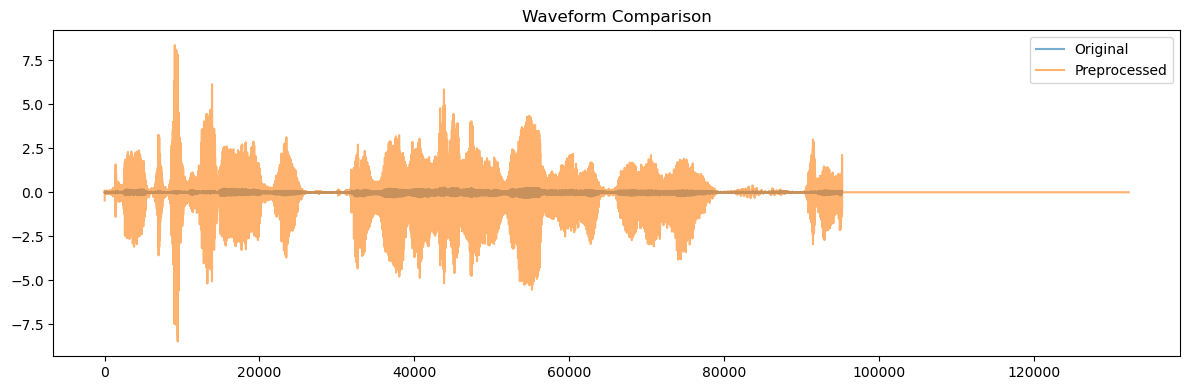

In [ ]:

import librosa
import noisereduce as nr
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

def preview_preprocessing(file_path, sr=22050, target_duration=6.0, apply_preemphasis=False, apply_reduction=False, coef=0.6, normalise='rms'):

    y, _ = librosa.load(file_path, sr=sr)
    y_orig = y.copy()

    # Trim silence
    y, _ = librosa.effects.trim(y)

    if apply_reduction:
        y = nr.reduce_noise(y=y, sr=sr)

    if apply_preemphasis:
        y = librosa.effects.preemphasis(y, coef=coef)

    # Choose normalisation method
    if normalise == 'rms':
        rms = np.sqrt(np.mean(y**2))
        y = y / (rms + 1e-6)
    elif normalise == 'peak':
        y = y / (np.max(np.abs(y)) + 1e-6)

    # Fix length
    target_len = int(sr * target_duration)
    if len(y) < target_len:
        y = np.pad(y, (0, target_len - len(y)))
    else:
        y = y[:target_len]

    print("Original:")
    ipd.display(ipd.Audio(y_orig, rate=sr))

    print("Preprocessed:")
    ipd.display(ipd.Audio(y, rate=sr))

    # Plot waveform comparison
    plt.figure(figsize=(12, 4))
    plt.plot(y_orig, label="Original", alpha=0.6)
    plt.plot(y, label="Preprocessed", alpha=0.6)
    plt.title("Waveform Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()


preview_preprocessing('datasets/vox1_subset_150/train_data/id10115/4cQ5Zgr-BK0/00001.wav', apply_preemphasis=True, apply_reduction=True, normalise='rms')





Feature extraction

In [115]:
import os
import librosa
import numpy as np
from pathlib import Path

# List of feature types
feature_types = ["mfcc", "chroma", "tonnetz", "spectral_contrast", "mel_spectrogram"]

# Base input and output
input_dir = Path("datasets/vox1_subset_150/val_data_preprocessed")
output_base = Path("datasets/vox1_subset_150/val_features")

def extract_feature(y, sr, feature_type):
    if feature_type == "mfcc":
        return librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    elif feature_type == "chroma":
        stft = np.abs(librosa.stft(y))
        return librosa.feature.chroma_stft(S=stft, sr=sr)
    elif feature_type == "tonnetz":
        y_harmonic = librosa.effects.harmonic(y)
        return librosa.feature.tonnetz(y=y_harmonic, sr=sr)
    elif feature_type == "spectral_contrast":
        stft = np.abs(librosa.stft(y))
        return librosa.feature.spectral_contrast(S=stft, sr=sr)
    elif feature_type == "mel_spectrogram":
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        return librosa.power_to_db(mel_spec, ref=np.max)
    else:
        raise ValueError(f"Unknown feature type: {feature_type}")

# Extract all features
for wav_path in input_dir.rglob("*.wav"):
    try:
        y, sr = librosa.load(wav_path, sr=22050)

        for feature_type in feature_types:
            feature = extract_feature(y, sr, feature_type)

            out_dir = output_base / feature_type
            relative = wav_path.relative_to(input_dir).with_suffix(".npy")
            out_path = out_dir / relative

            out_path.parent.mkdir(parents=True, exist_ok=True)
            np.save(out_path, feature)

    except Exception as e:
        print(f"Failed to process {wav_path}: {e}")

print("Feature extraction complete.")


Feature extraction complete.


Analysing some features 

In [116]:
#gettgin teh shape to know wqhat the 2d cCNN input shape should be
mel_path = os.path.join(
    os.getcwd(), r'datasets/vox1_subset_150/features_aligned_ready/mel_spectrogram/id10002/6WO410QOeuo/00003.npy'
)
#ml-models\datasets\vox1_subset_150\features_aligned_ready\mel_spectrogram\id10002\6WO410QOeuo
mel_spectrogram = np.load(mel_path)

print("Shape of mel spectrogram:", mel_spectrogram.shape)
print("Size of mel spectrogram:", mel_spectrogram.size)


Shape of mel spectrogram: (128, 259)
Size of mel spectrogram: 33152


Model creations





In [162]:
import torch
import torch.nn as nn
import torch.nn.functional as F


#2D Comvolutional Neural Network - MEL SPECTROGRAM
"""
class ConvolutionGRUBlock(nn.Module):
    def __init__(self):
        super(ConvolutionGRUBlock, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.AvgPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.AvgPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.AvgPool2d(2, 2)

        self.dropout = nn.Dropout(0.3)

        self.gru_input_size = 128 * 16
        self.gru = nn.GRU(input_size=self.gru_input_size, hidden_size=512, num_layers=2,
                          batch_first=True, bidirectional=True)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = self.dropout(x)

        x = x.permute(0, 3, 1, 2)       # (B, T, C, F)
        x = x.reshape(x.size(0), 32, -1)  # (B, T=32, features=2048)

        x, _ = self.gru(x)  # (B, T, 1024)
        x = x[:, -1, :]     # Last time step → (B, 1024)
        return x
"""

class ConvolutionLSTMBlock(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.AvgPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.AvgPool2d(2)


        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.AvgPool2d(2)


        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.AdaptiveAvgPool2d((32, 8))  # keep time steps manageable

        self.dropout = nn.Dropout(0.1)

        self.lstm = nn.LSTM(input_size=8 * 256, hidden_size=512,
                            num_layers=2, batch_first=True, bidirectional=True)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        
        x = self.pool1(x)

        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)


        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)

        x = self.dropout(x)
        x = x.permute(0, 2, 1, 3).reshape(x.size(0), 32, -1)

        out, _ = self.lstm(x)
        return out[:, -1, :]  # take last time step




#Dense Neural Network - base model, apply the number of fatures in the output_dim for each, as these vary.

import torch
import torch.nn as nn
import torch.nn.functional as F

class DenseNeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim=128):
        super(DenseNeuralNetwork, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        
        self.fc2 = nn.Linear(256, 256)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.fc3 = nn.Linear(256, output_dim)
        self.bn3 = nn.BatchNorm1d(output_dim)

        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        
        x = self.relu(self.bn3(self.fc3(x)))
        return x
    


"""
    #concatenate the outputs of the two models, and add a final dense layer for classification
class AudioFusionModel(nn.Module):
    def __init__(self, num_classes):
        super(AudioFusionModel, self).__init__()

        # CNN + GRU for mel
        self.mel_branch = ConvolutionGRUBlock()

        # DNNs for the other features
        self.mfcc_branch     = DenseNeuralNetwork(input_dim=40)# 40 featres froim mfcc
        self.chroma_branch   = DenseNeuralNetwork(input_dim=12)#base default 
        self.tonnetz_branch  = DenseNeuralNetwork(input_dim=6)#base
        self.contrast_branch = DenseNeuralNetwork(input_dim=7,output_dim=128)#base

        # Fusion & output
        self.fc_fusion = nn.Linear(1024 + 4*128, 256)
        self.dropout = nn.Dropout(0.3)  # add this
        self.fc_out = nn.Linear(256, num_classes)

    def forward(self, mel, mfcc, chroma, tonnetz, contrast):
        mel_out     = self.mel_branch(mel)
        mfcc_out     = self.mfcc_branch(mfcc)
        chroma_out   = self.chroma_branch(chroma)
        tonnetz_out  = self.tonnetz_branch(tonnetz)
        contrast_out = self.contrast_branch(contrast)

        combined = torch.cat([mel_out, mfcc_out, chroma_out, tonnetz_out, contrast_out], dim=1)
        fusion = F.leaky_relu(self.fc_fusion(combined))
        fusion = self.dropout(fusion)  
        out = self.fc_out(fusion)
        return out

"""

class AudioFusionModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.mel_branch = ConvolutionLSTMBlock()
        self.mfcc_branch = DenseNeuralNetwork(input_dim=40)
        self.chroma_branch = DenseNeuralNetwork(input_dim=12)
        self.tonnetz_branch = DenseNeuralNetwork(input_dim=6)
        self.contrast_branch = DenseNeuralNetwork(input_dim=7)

        self.fc_fusion = nn.Sequential(
            nn.Linear(1024 + 4 * 128, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),  
            nn.Dropout(0.1),
        )

        self.fc_out = nn.Linear(256, num_classes)

    def forward(self, mel, mfcc, chroma, tonnetz, contrast):
        mel_out = self.mel_branch(mel)
        mfcc_out = self.mfcc_branch(mfcc)
        chroma_out = self.chroma_branch(chroma)
        tonnetz_out = self.tonnetz_branch(tonnetz)
        contrast_out = self.contrast_branch(contrast)

        combined = torch.cat([mel_out, mfcc_out, chroma_out, tonnetz_out, contrast_out], dim=1)
        fusion = self.fc_fusion(combined)
        return self.fc_out(fusion)


build the dataset for the input for the modoles



In [163]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from glob import glob

class AudioFeatureDataset(Dataset):
    def __init__(self, base_path):
        self.base_path = base_path
        self.feature_dirs = {
            "mel": "mel_spectrogram",
            "mfcc": "mfcc",
            "chroma": "chroma",
            "tonnetz": "tonnetz",
            "contrast": "spectral_contrast"
        }

        # Collect relative paths from one feature folder (e.g. mel)
        mel_folder = os.path.join(base_path, self.feature_dirs['mel'])
        rel_paths = glob(os.path.join(mel_folder, "*", "*", "*.npy"))
        self.valid_paths = [
            os.path.relpath(path, mel_folder)
            for path in rel_paths
        ]

        # Filter to only keep files that exist in all 5 folders
        self.valid_paths = [
            rel_path for rel_path in self.valid_paths
            if all(
                os.path.exists(os.path.join(base_path, folder, rel_path))
                for folder in self.feature_dirs.values()
            )
        ]

      
        speaker_ids = sorted(set(p.split(os.sep)[0] for p in self.valid_paths))
        self.label_map = {speaker: idx for idx, speaker in enumerate(speaker_ids)}

        print(f"[INFO] Loaded {len(self.valid_paths)} aligned samples")
        print(f"[INFO] Number of speaker classes: {len(self.label_map)}")

    def __len__(self):
        return len(self.valid_paths)

    def __getitem__(self, idx):
        rel_path = self.valid_paths[idx]
        speaker_id = rel_path.split(os.sep)[0]
        label = self.label_map[speaker_id]

        def load(feature):
            path = os.path.join(self.base_path, self.feature_dirs[feature], rel_path)
            return np.load(path)

        mfcc = torch.tensor(load("mfcc"), dtype=torch.float32).mean(dim=1)     
        chroma = torch.tensor(load("chroma"), dtype=torch.float32).mean(dim=1)  
        tonnetz = torch.tensor(load("tonnetz"), dtype=torch.float32).mean(dim=1) 
        contrast = torch.tensor(load("contrast"), dtype=torch.float32).mean(dim=1)  
        mel = torch.tensor(load("mel"), dtype=torch.float32).unsqueeze(0)  


        return mel, mfcc, chroma, tonnetz, contrast, torch.tensor(label)



Training and metrics 

In [165]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train(model, dataset, num_classes, epochs=60, batch_size=32, lr=0.0005, device='cuda'):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr=lr)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for mel, mfcc, chroma, tonnetz, contrast, labels in loop:
            mel, mfcc, chroma, tonnetz, contrast, labels = (
                mel.to(device),
                mfcc.to(device),
                chroma.to(device),
                tonnetz.to(device),
                contrast.to(device),
                labels.to(device)
            )

            outputs = model(mel, mfcc, chroma, tonnetz, contrast)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            total_loss += loss.item() * labels.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item(), acc=100.0 * correct / total)

        epoch_loss = total_loss / total
        epoch_acc = 100.0 * correct / total
        print(f"Epoch {epoch+1} finished | Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%\n")
       #
        scheduler.step()
        for param_group in optimizer.param_groups:
            print(f"[INFO] Learning rate: {param_group['lr']:.6f}")






In [169]:
import os

mel_path = "datasets/vox1_subset_150/val_features/mel_spectrogram"
num_classes = len([d for d in os.listdir(mel_path) if os.path.isdir(os.path.join(mel_path, d))])
print(f"Number of speaker classes: {num_classes}")



Number of speaker classes: 30


In [ ]:
dataset = AudioFeatureDataset("datasets/vox1_subset_150/val_features")
model = AudioFusionModel(num_classes=len(dataset.label_map))
#train(model, dataset,30)


[INFO] Loaded 3353 aligned samples
[INFO] Number of speaker classes: 30


Epoch 1/60: 100%|██████████| 105/105 [01:36<00:00,  1.09it/s, acc=12.4, loss=2.7] 


Epoch 1 finished | Loss: 3.1204, Accuracy: 12.44%

[INFO] Learning rate: 0.000500


Epoch 2/60: 100%|██████████| 105/105 [00:10<00:00,  9.99it/s, acc=29.1, loss=1.74]


Epoch 2 finished | Loss: 2.3292, Accuracy: 29.08%

[INFO] Learning rate: 0.000500


Epoch 3/60: 100%|██████████| 105/105 [00:10<00:00,  9.93it/s, acc=39.9, loss=2.26]


Epoch 3 finished | Loss: 1.9765, Accuracy: 39.87%

[INFO] Learning rate: 0.000500


Epoch 4/60: 100%|██████████| 105/105 [00:10<00:00, 10.11it/s, acc=45.8, loss=1.46]


Epoch 4 finished | Loss: 1.7400, Accuracy: 45.75%

[INFO] Learning rate: 0.000500


Epoch 5/60: 100%|██████████| 105/105 [00:10<00:00, 10.14it/s, acc=52.2, loss=1.44]


Epoch 5 finished | Loss: 1.5326, Accuracy: 52.19%

[INFO] Learning rate: 0.000500


Epoch 6/60: 100%|██████████| 105/105 [00:10<00:00, 10.14it/s, acc=56.4, loss=1.86] 


Epoch 6 finished | Loss: 1.3910, Accuracy: 56.37%

[INFO] Learning rate: 0.000500


Epoch 7/60: 100%|██████████| 105/105 [00:10<00:00, 10.15it/s, acc=59.8, loss=0.955]


Epoch 7 finished | Loss: 1.2766, Accuracy: 59.77%

[INFO] Learning rate: 0.000500


Epoch 8/60: 100%|██████████| 105/105 [00:10<00:00, 10.14it/s, acc=63, loss=1.41]  


Epoch 8 finished | Loss: 1.1864, Accuracy: 62.99%

[INFO] Learning rate: 0.000500


Epoch 9/60: 100%|██████████| 105/105 [00:10<00:00, 10.11it/s, acc=65.8, loss=1.02] 


Epoch 9 finished | Loss: 1.0921, Accuracy: 65.79%

[INFO] Learning rate: 0.000500


Epoch 10/60: 100%|██████████| 105/105 [00:10<00:00, 10.10it/s, acc=68.9, loss=1.31] 


Epoch 10 finished | Loss: 0.9810, Accuracy: 68.86%

[INFO] Learning rate: 0.000250


Epoch 11/60: 100%|██████████| 105/105 [00:10<00:00, 10.08it/s, acc=75.3, loss=0.961]


Epoch 11 finished | Loss: 0.7872, Accuracy: 75.34%

[INFO] Learning rate: 0.000250


Epoch 12/60: 100%|██████████| 105/105 [00:10<00:00, 10.14it/s, acc=77.4, loss=0.452]


Epoch 12 finished | Loss: 0.7067, Accuracy: 77.39%

[INFO] Learning rate: 0.000250


Epoch 13/60: 100%|██████████| 105/105 [00:10<00:00, 10.14it/s, acc=80.9, loss=0.406]


Epoch 13 finished | Loss: 0.5927, Accuracy: 80.91%

[INFO] Learning rate: 0.000250


Epoch 14/60: 100%|██████████| 105/105 [00:10<00:00, 10.12it/s, acc=83.6, loss=0.773]


Epoch 14 finished | Loss: 0.5069, Accuracy: 83.63%

[INFO] Learning rate: 0.000250


Epoch 15/60: 100%|██████████| 105/105 [00:10<00:00, 10.15it/s, acc=85.4, loss=0.266]


Epoch 15 finished | Loss: 0.4348, Accuracy: 85.39%

[INFO] Learning rate: 0.000250


Epoch 16/60: 100%|██████████| 105/105 [00:10<00:00, 10.14it/s, acc=87.7, loss=0.432]


Epoch 16 finished | Loss: 0.3918, Accuracy: 87.68%

[INFO] Learning rate: 0.000250


Epoch 17/60: 100%|██████████| 105/105 [00:10<00:00, 10.16it/s, acc=90, loss=0.369]  


Epoch 17 finished | Loss: 0.3092, Accuracy: 90.04%

[INFO] Learning rate: 0.000250


Epoch 18/60: 100%|██████████| 105/105 [00:10<00:00, 10.09it/s, acc=91.6, loss=0.109]


Epoch 18 finished | Loss: 0.2627, Accuracy: 91.62%

[INFO] Learning rate: 0.000250


Epoch 19/60: 100%|██████████| 105/105 [00:10<00:00, 10.18it/s, acc=93.3, loss=0.183] 


Epoch 19 finished | Loss: 0.2237, Accuracy: 93.29%

[INFO] Learning rate: 0.000250


Epoch 20/60: 100%|██████████| 105/105 [00:10<00:00, 10.19it/s, acc=94.9, loss=0.249] 


Epoch 20 finished | Loss: 0.1771, Accuracy: 94.90%

[INFO] Learning rate: 0.000125


Epoch 21/60: 100%|██████████| 105/105 [00:10<00:00,  9.98it/s, acc=96.6, loss=0.127] 


Epoch 21 finished | Loss: 0.1192, Accuracy: 96.63%

[INFO] Learning rate: 0.000125


Epoch 22/60: 100%|██████████| 105/105 [00:22<00:00,  4.70it/s, acc=96.8, loss=0.0551]


Epoch 22 finished | Loss: 0.1059, Accuracy: 96.84%

[INFO] Learning rate: 0.000125


Epoch 23/60: 100%|██████████| 105/105 [00:27<00:00,  3.76it/s, acc=97.8, loss=0.0371]


Epoch 23 finished | Loss: 0.0708, Accuracy: 97.82%

[INFO] Learning rate: 0.000125


Epoch 24/60: 100%|██████████| 105/105 [00:44<00:00,  2.37it/s, acc=98.4, loss=0.0323]


Epoch 24 finished | Loss: 0.0578, Accuracy: 98.42%

[INFO] Learning rate: 0.000125


Epoch 25/60: 100%|██████████| 105/105 [00:16<00:00,  6.56it/s, acc=98.8, loss=0.034]  


Epoch 25 finished | Loss: 0.0507, Accuracy: 98.81%

[INFO] Learning rate: 0.000125


Epoch 26/60: 100%|██████████| 105/105 [00:17<00:00,  5.93it/s, acc=98.6, loss=0.0141] 


Epoch 26 finished | Loss: 0.0534, Accuracy: 98.57%

[INFO] Learning rate: 0.000125


Epoch 27/60: 100%|██████████| 105/105 [00:15<00:00,  6.61it/s, acc=98.8, loss=0.00917]


Epoch 27 finished | Loss: 0.0488, Accuracy: 98.81%

[INFO] Learning rate: 0.000125


Epoch 28/60: 100%|██████████| 105/105 [00:15<00:00,  6.67it/s, acc=98.9, loss=0.0531]


Epoch 28 finished | Loss: 0.0421, Accuracy: 98.93%

[INFO] Learning rate: 0.000125


Epoch 29/60: 100%|██████████| 105/105 [00:15<00:00,  6.58it/s, acc=98.9, loss=0.0192] 


Epoch 29 finished | Loss: 0.0427, Accuracy: 98.93%

[INFO] Learning rate: 0.000125


Epoch 30/60: 100%|██████████| 105/105 [00:15<00:00,  6.65it/s, acc=98.7, loss=0.1]    


Epoch 30 finished | Loss: 0.0419, Accuracy: 98.75%

[INFO] Learning rate: 0.000063


Epoch 31/60: 100%|██████████| 105/105 [00:17<00:00,  5.88it/s, acc=99.2, loss=0.0229] 


Epoch 31 finished | Loss: 0.0308, Accuracy: 99.16%

[INFO] Learning rate: 0.000063


Epoch 32/60: 100%|██████████| 105/105 [00:15<00:00,  7.00it/s, acc=99.3, loss=0.0797] 


Epoch 32 finished | Loss: 0.0265, Accuracy: 99.34%

[INFO] Learning rate: 0.000063


Epoch 33/60: 100%|██████████| 105/105 [00:13<00:00,  7.97it/s, acc=99.4, loss=0.0852] 


Epoch 33 finished | Loss: 0.0243, Accuracy: 99.40%

[INFO] Learning rate: 0.000063


Epoch 34/60: 100%|██████████| 105/105 [00:30<00:00,  3.47it/s, acc=99.2, loss=0.12]   


Epoch 34 finished | Loss: 0.0250, Accuracy: 99.16%

[INFO] Learning rate: 0.000063


Epoch 35/60: 100%|██████████| 105/105 [00:41<00:00,  2.54it/s, acc=99.5, loss=0.0301]


Epoch 35 finished | Loss: 0.0195, Accuracy: 99.52%

[INFO] Learning rate: 0.000063


Epoch 36/60: 100%|██████████| 105/105 [00:34<00:00,  3.05it/s, acc=99.4, loss=0.0526] 


Epoch 36 finished | Loss: 0.0218, Accuracy: 99.40%

[INFO] Learning rate: 0.000063


Epoch 37/60: 100%|██████████| 105/105 [00:21<00:00,  4.78it/s, acc=99.5, loss=0.0672] 


Epoch 37 finished | Loss: 0.0197, Accuracy: 99.49%

[INFO] Learning rate: 0.000063


Epoch 38/60: 100%|██████████| 105/105 [00:20<00:00,  5.09it/s, acc=99.6, loss=0.015]   


Epoch 38 finished | Loss: 0.0157, Accuracy: 99.64%

[INFO] Learning rate: 0.000063


Epoch 39/60: 100%|██████████| 105/105 [00:21<00:00,  4.94it/s, acc=99.6, loss=0.0725] 


Epoch 39 finished | Loss: 0.0171, Accuracy: 99.64%

[INFO] Learning rate: 0.000063


Epoch 40/60: 100%|██████████| 105/105 [00:22<00:00,  4.67it/s, acc=99.4, loss=0.014]  


Epoch 40 finished | Loss: 0.0191, Accuracy: 99.43%

[INFO] Learning rate: 0.000031


Epoch 41/60: 100%|██████████| 105/105 [00:20<00:00,  5.08it/s, acc=99.6, loss=0.00581]


Epoch 41 finished | Loss: 0.0193, Accuracy: 99.58%

[INFO] Learning rate: 0.000031


Epoch 42/60: 100%|██████████| 105/105 [00:21<00:00,  4.90it/s, acc=99.8, loss=0.000943]


Epoch 42 finished | Loss: 0.0131, Accuracy: 99.79%

[INFO] Learning rate: 0.000031


Epoch 43/60: 100%|██████████| 105/105 [00:22<00:00,  4.58it/s, acc=99.8, loss=0.0158]  


Epoch 43 finished | Loss: 0.0131, Accuracy: 99.76%

[INFO] Learning rate: 0.000031


Epoch 44/60: 100%|██████████| 105/105 [00:22<00:00,  4.74it/s, acc=99.9, loss=0.00219]


Epoch 44 finished | Loss: 0.0086, Accuracy: 99.85%

[INFO] Learning rate: 0.000031


Epoch 45/60: 100%|██████████| 105/105 [00:19<00:00,  5.26it/s, acc=99.8, loss=0.0191] 


Epoch 45 finished | Loss: 0.0101, Accuracy: 99.79%

[INFO] Learning rate: 0.000031


Epoch 46/60: 100%|██████████| 105/105 [00:21<00:00,  4.83it/s, acc=99.8, loss=0.0928] 


Epoch 46 finished | Loss: 0.0111, Accuracy: 99.76%

[INFO] Learning rate: 0.000031


Epoch 47/60: 100%|██████████| 105/105 [00:21<00:00,  4.90it/s, acc=99.8, loss=0.0144]  


Epoch 47 finished | Loss: 0.0093, Accuracy: 99.82%

[INFO] Learning rate: 0.000031


Epoch 48/60: 100%|██████████| 105/105 [00:22<00:00,  4.62it/s, acc=99.8, loss=0.0016] 


Epoch 48 finished | Loss: 0.0106, Accuracy: 99.76%

[INFO] Learning rate: 0.000031


Epoch 49/60: 100%|██████████| 105/105 [00:22<00:00,  4.73it/s, acc=99.8, loss=0.0055]  


Epoch 49 finished | Loss: 0.0094, Accuracy: 99.79%

[INFO] Learning rate: 0.000031


Epoch 50/60: 100%|██████████| 105/105 [00:21<00:00,  4.98it/s, acc=99.9, loss=0.0059] 


Epoch 50 finished | Loss: 0.0087, Accuracy: 99.88%

[INFO] Learning rate: 0.000016


Epoch 51/60: 100%|██████████| 105/105 [00:21<00:00,  4.98it/s, acc=99.8, loss=0.00612]


Epoch 51 finished | Loss: 0.0090, Accuracy: 99.76%

[INFO] Learning rate: 0.000016


Epoch 52/60: 100%|██████████| 105/105 [00:20<00:00,  5.15it/s, acc=99.8, loss=0.00847] 


Epoch 52 finished | Loss: 0.0085, Accuracy: 99.79%

[INFO] Learning rate: 0.000016


Epoch 53/60: 100%|██████████| 105/105 [00:21<00:00,  4.96it/s, acc=99.8, loss=0.00258]


Epoch 53 finished | Loss: 0.0086, Accuracy: 99.79%

[INFO] Learning rate: 0.000016


Epoch 54/60: 100%|██████████| 105/105 [00:24<00:00,  4.28it/s, acc=99.9, loss=0.0104] 


Epoch 54 finished | Loss: 0.0096, Accuracy: 99.91%

[INFO] Learning rate: 0.000016


Epoch 55/60: 100%|██████████| 105/105 [00:21<00:00,  4.92it/s, acc=99.9, loss=0.000795]


Epoch 55 finished | Loss: 0.0057, Accuracy: 99.94%

[INFO] Learning rate: 0.000016


Epoch 56/60: 100%|██████████| 105/105 [00:21<00:00,  4.87it/s, acc=99.8, loss=0.00823]


Epoch 56 finished | Loss: 0.0087, Accuracy: 99.79%

[INFO] Learning rate: 0.000016


Epoch 57/60: 100%|██████████| 105/105 [00:22<00:00,  4.58it/s, acc=99.9, loss=0.0419] 


Epoch 57 finished | Loss: 0.0068, Accuracy: 99.88%

[INFO] Learning rate: 0.000016


Epoch 58/60: 100%|██████████| 105/105 [00:24<00:00,  4.33it/s, acc=99.9, loss=0.00243]


Epoch 58 finished | Loss: 0.0054, Accuracy: 99.94%

[INFO] Learning rate: 0.000016


Epoch 59/60: 100%|██████████| 105/105 [00:19<00:00,  5.27it/s, acc=99.9, loss=0.00391] 


Epoch 59 finished | Loss: 0.0058, Accuracy: 99.91%

[INFO] Learning rate: 0.000016


Epoch 60/60: 100%|██████████| 105/105 [00:19<00:00,  5.46it/s, acc=99.9, loss=0.00373] 

Epoch 60 finished | Loss: 0.0073, Accuracy: 99.91%

[INFO] Learning rate: 0.000008


In [171]:

#save modeel

torch.save(model.state_dict(), "1.4_val_LSTM_audio_fusion_99acc.pth")
#load that model, it only saves the weights, not the model architecture:



Evaluation

In [ ]:
#testing the new upated model


SyntaxError: 'return' outside function (459767717.py, line 2)